In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Reshape, Dropout
from keras.optimizers import SGD,Adam
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2


In [ ]:
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

#Loading the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

# Preprocessing, scaling the data, and one-hot-encoding our 'output'
X_train_scaled = X_train.astype('float32') / 255.0

y_train_encoded = to_categorical(y_train, num_classes=10)

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
X_test = X_test.astype('float32') / 255.0
y_test_encoded = to_categorical(y_test, num_classes=10)

In [ ]:
model = Sequential()

# Input layer
model.add(Flatten(input_shape=(32, 32, 3)))

# Hidden layers with dropout and L2 regularization
model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
# Compile the model

optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define the training parameters
epochs = 100
batch_size = 1024

# Train the model
early_stop = EarlyStopping(monitor='val_accuracy', patience=10)

history = model.fit(X_train_scaled, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks = early_stop)



In [ ]:
score = model.evaluate(X_test, y_test_encoded, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

Test loss: 1.5278288125991821
Test accuracy: 51.010000705718994 %


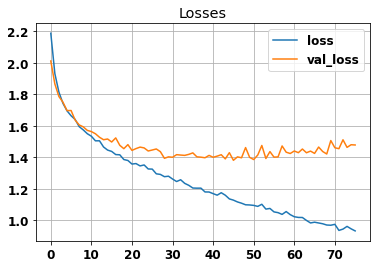

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Losses')
plt.grid(True)
plt.legend()

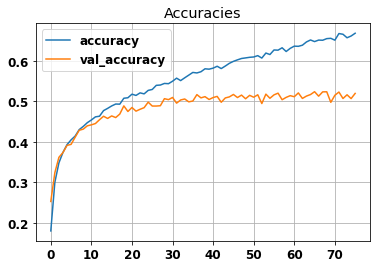

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracies')
plt.grid(True)
plt.legend()

In [ ]:
def show_the_best_predictions(model, x_test: np.array, y_test: np.array, n_of_pred: int = 10) -> None:
  mapping = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

  predictions = model.predict(x_test)
  y_test = y_test.reshape(1,-1)
  predictions_ind = np.argmax(predictions, axis=1)
  predictions_ind = predictions_ind.reshape(1, -1)

  corect_predictions = np.where(predictions_ind == y_test)

  rows_correct = corect_predictions[1]
  predictedtions_correct = predictions[rows_correct]
  target_correct = y_test[0][rows_correct]

  max_samples = predictions[rows_correct, target_correct]
  selected_images = x_test[rows_correct]
  sorted_ind = np.argsort(max_samples)[::-1]


  images = []
  prob = []
  labels = []


  for ind in range(n_of_pred):

    index = sorted_ind[ind]

    labels.append(target_correct[index])
    prob.append(max_samples[index])
    images.append(selected_images[index])

  plt.figure(figsize=(20,10))
  
  images = np.concatenate(np.asarray(images),axis=1)
  plt.imshow(images)
  for ins in range(n_of_pred):
    texts = '{}: \n{:.3f} %'.format(mapping[labels[ins]], prob[ins]*100)
    plt.text((32/2) + 32*ins - len(mapping[labels[ins]]), 32*(5/4), texts)

  plt.axis('off')
  plt.show()

313/313 [==============================] - 1s 3ms/step


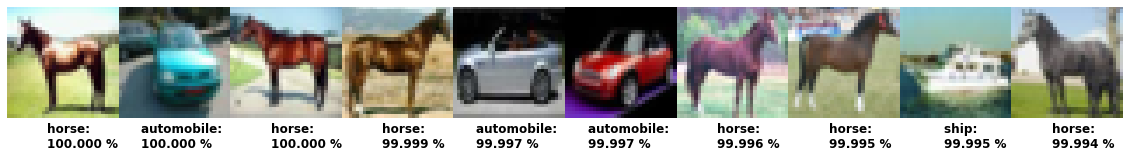

In [ ]:
show_the_best_predictions(model, X_test, y_test)

We define a function that returns the Keras model we want to tune. We can use this function in GridSearchCV to test different hyperparameters.

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def create_model(optimizer='adam', dropout_rate=0.0, l2_reg=0.0):
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:
# Define hyperparameters
param_grid = {'optimizer': ['adam', 'sgd', 'rmsprop'],
              'dropout_rate': [0.0, 0.1, 0.2],
              'l2_reg': [0.0, 0.001, 0.01]}

# Create Keras model
early_stop = EarlyStopping(monitor='val_accuracy', patience=10)
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=1024, verbose=0, callbacks = early_stop)

# Use GridSearchCV to test different hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_scaled, y_train_encoded)

# Print best hyperparameters and accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


<ipython-input-11-dbd9af2cf054>:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=1024, verbose=0)
/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
